## Analysis of 1st day in the RCF study
Checking amygdala activation in the CS+US condition of the task
- masking amygdala
- avergaing activation
- plot

In [3]:
# load libraries
import glob
import pandas as pd
import numpy as np
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import cmdstanpy

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
## Screening subjects by SCR as Nachshon analyzed - 67% as US:
subject_list = ['029','040','1074','1205','1223','1237','1245','1247',
               '1280','1301','1337','1350','1359','1374','1392','020',
               '1072','1099','1206','1212','1216','1258','1266','1268',
               '1320','1340','1345','1346','1362','1379','1393','1457','1460',
               '1373','1272','1291','1309'] # '1269','1271','1319', '1220','1376',
len(subject_list)

37

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/nilearn/_utils/helpers.py:145: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  return func(*args, **kwargs)


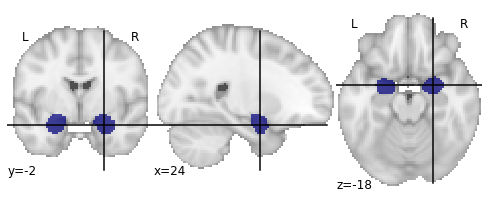

In [5]:
# load mask
mask_file = 'amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=20", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)

# create a masker 
fwhm = 4
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               sessions=None, smoothing_fwhm=fwhm, standardize=False, 
                                        detrend=False, verbose=5)

In [6]:
#us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/cope{cope_num}.nii.gz'
us_cond = '/media/Data/work/RCF_FSLNoScrub/Sink_respNOScrub/1stLevel/_subject_id_{sub}/_modelestimate0/results/zstat{cope_num}.nii.gz'
cope_num =  4#taking shock vs. noshock


In [ ]:
us = []
timeseriesAmg = []
counter = 1 # set counter to give percentage of progress
for sub in subject_list:
   # try:
    func = us_cond.format(sub=sub, cope_num= cope_num)
    print(func)
    sub = func.split('id_')[1].split('/')[0]
    print(sub)
    print(f'\nFinished {counter/len(subject_list)*100}% of subjects')
    counter = counter +1 
    # amygdala
    tArr = masker.fit_transform(func)
    meanT = np.mean(tArr,axis=1)
    sem = scipy.stats.sem(tArr, axis=1)
    std = np.std(tArr, axis=1)
    

    # create datafram for the timeseries
    dfTS = {'subject':sub, 'ts':tArr[0]}
    # create dataframe for the mean activation
    df = {'subject':sub, 'amygdala':meanT[0], 'amgsem':sem[0], 'amgstd':std[0]}
    #df['subject'] = sub
    us.append(df)
    timeseriesAmg.append(dfTS)
    #except:
     #   print(f'Subject {sub} has no data')
amg_ud = pd.DataFrame(us)
tsDf = pd.DataFrame(timeseriesAmg)

In [8]:
amg_ud.head()

,subject,amygdala,amgsem,amgstd
0,029,0.480097,0.027650,0.843667
1,040,0.470255,0.022986,0.701370
2,1074,0.045975,0.026153,0.797999
3,1205,0.679076,0.020865,0.636649
4,1223,0.150069,0.021399,0.652942


## look at group differences

In [9]:
groupDF = pd.read_csv('groups.csv')
groupDF['subject'] = groupDF['subject'].astype(int).astype(str)
for i in groupDF.iterrows():
    # change two numbers to three
    if len(i[1].subject) < 4:
        groupDF.at[i[0],'subject'] = '0' + i[1].subject


groupDF.head()

,group,subject
0,PTSD,035
1,CC,011
2,PTSD,040
3,PTSD,029
4,CC,020


In [10]:
groupDF.groupby(['group']).count()

,subject
group,
CC,26
PTSD,27


In [11]:
# merge group and stimulus data
dfAll = pd.merge(groupDF, amg_ud)
dfAll.head()

,group,subject,amygdala,amgsem,amgstd
0,PTSD,040,0.470255,0.022986,0.701370
1,PTSD,029,0.480097,0.027650,0.843667
2,CC,020,0.260270,0.022249,0.678866
3,CC,1072,0.893891,0.022684,0.692152
4,PTSD,1074,0.045975,0.026153,0.797999


<AxesSubplot:title={'center':'amygdala'}, xlabel='group', ylabel='amygdala'>

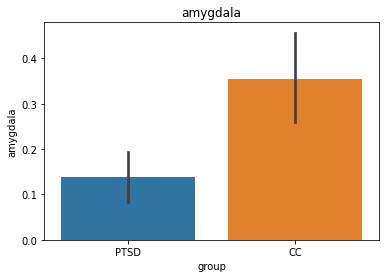

In [12]:
# Plot barplot to see differences
plt.title("amygdala")
sns.barplot(x="group", y="amygdala", data=dfAll, ci=68)

In [14]:
# run simple one-tailed t-test
t = scipy.stats.ttest_ind(dfAll['amygdala'][dfAll['group']=='CC'],dfAll['amygdala'][dfAll['group']=='PTSD'], 
                     equal_var = True)

# one tailed
t[1] /2

0.03410260419452769

## Use STAN to check differences

In [15]:
#To select rows whose column value is in list 
groups = ["CC", "PTSD"]
dg = dfAll[dfAll.group.isin(groups)]

# changing group to numbers before we run stan model
group = {'CC': 0,'PTSD': 1} 
dg.group = [group[item] for item in dg.group] 
dg.head()

,group,subject,amygdala,amgsem,amgstd
0,1,040,0.470255,0.022986,0.701370
1,1,029,0.480097,0.027650,0.843667
2,0,020,0.260270,0.022249,0.678866
3,0,1072,0.893891,0.022684,0.692152
4,1,1074,0.045975,0.026153,0.797999


In [16]:
# how many in each group
dg.groupby(['group']).count()

,subject,amygdala,amgsem,amgstd
group,,,,
0,19,19,19,19
1,18,18,18,18


In [17]:
data =  {'N': len(dg), 'x': dg['group'].values, 'y': dg['amygdala'].values}
sm = cmdstanpy.CmdStanModel(stan_file='Stan_model/simple_model.stan')


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/or/SIA_PTSD/Stan_model/simple_model


In [18]:
# Train the model and generate samples
fit_simple_model = sm.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  #inits = 0.2,
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [19]:
#fit
fit_simple_model.summary(percentiles=(1,95))

,Mean,MCSE,StdDev,1%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,19.00,0.03300,1.300,15.00,20.000,1500.0,17000.0,1.0
alpha,0.35,0.00180,0.083,0.16,0.490,2100.0,25000.0,1.0
beta,-0.22,0.00260,0.120,-0.49,-0.026,2100.0,25000.0,1.0
sigma,0.36,0.00094,0.045,0.28,0.440,2300.0,27000.0,1.0


In [20]:
# # Extracting traces
alpha = fit_simple_model.stan_variable(name='alpha')
beta = fit_simple_model.stan_variable(name='beta')
sigma = fit_simple_model.stan_variable(name='sigma')
#lp = fit_simple_model.stan_variable(name='lp')

0.032749999999999946

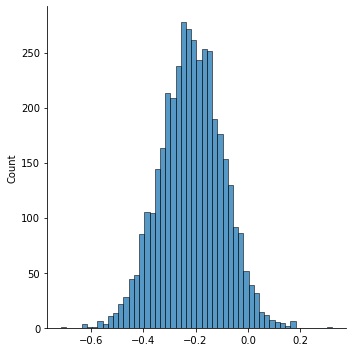

In [21]:
sns.displot(beta)
1 - sum(beta<0) / len(beta)

# Check correlation between amg and behavior

In [22]:
dfPCL = pd.read_csv('pclScores.csv')
# remove the RCF from beginning of subject id
dfPCL['subject'] = dfPCL['subject'].astype(str)
# because some subjects has two digits, we add zero
for i in dfPCL.iterrows():
    if len(i[1].subject) < 4:
        dfPCL.at[i[0],'subject'] = '0' + i[1].subject

dfPCL.head()

,group,subject,pcl_An,pcl_Av,pcl_total
0,PTSD,035,7.0,6.0,43.0
1,CC,011,0.0,0.0,0.0
2,PTSD,040,5.0,4.0,24.0
3,PTSD,029,0.0,1.0,11.0
4,CC,020,0.0,0.0,0.0


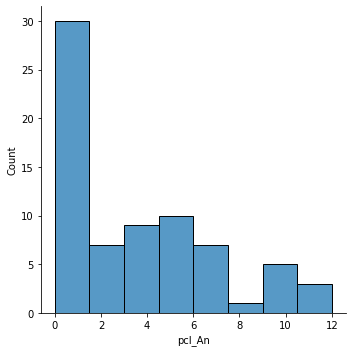

In [23]:
sns.displot(dfPCL.pcl_An)

In [24]:
groups = ["CC", "PTSD"]
dfpcl_amg = pd.merge(dfPCL, amg_ud)
dfpcl_amg = dfpcl_amg[dfpcl_amg.group.isin(groups)]

## Use function to get both R and CI
 - consider using pyStan for that also

In [ ]:
def pearsonr_ci(x,y,alpha=0.05):
    from scipy import stats
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [ ]:
## Correlation to two groups
pearsonr_ci(dfpcl_amg['pcl_An'], dfpcl_amg['amygdala'])

In [ ]:
## correlation only for PTSD group
dfpcl_ptsd = dfpcl_amg[dfpcl_amg.group=='PTSD']
pearsonr_ci(dfpcl_ptsd['pcl_An'], dfpcl_ptsd['amygdala'])

In [ ]:
## correlation only for Combat Controls group
dfpcl_cc = dfpcl_amg[dfpcl_amg.group=='CC']
pearsonr_ci(dfpcl_cc['pcl_An'], dfpcl_cc['amygdala'])

## generate publication plots

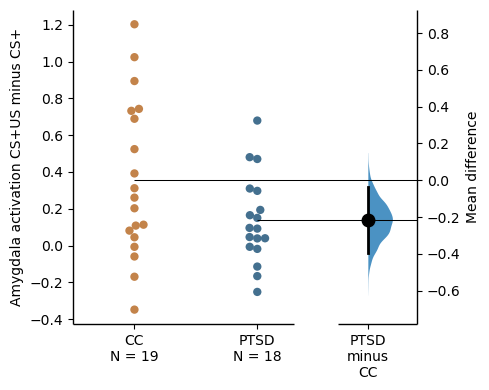

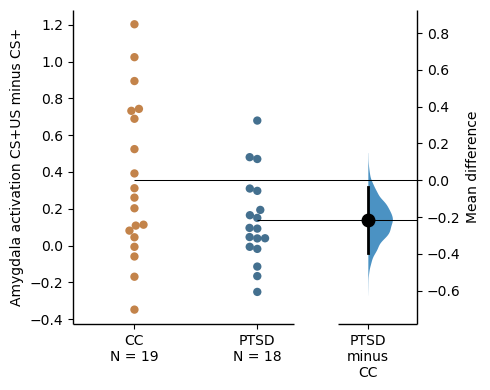

In [25]:
import dabest
groups = ["CC", "PTSD"]
dgr = dfAll[dfAll.group.isin(groups)]

# load our data to dabest to produce graphs
dgr = dgr.rename(columns={"amygdala": "Amygdala activation CS+US minus CS+", "group": "Group"})
dgr_dabest = dabest.load(data=dgr, x='Group', y='Amygdala activation CS+US minus CS+', 
                                  idx=('CC','PTSD'), ci=90)
dgr_dabest.mean_diff.plot()

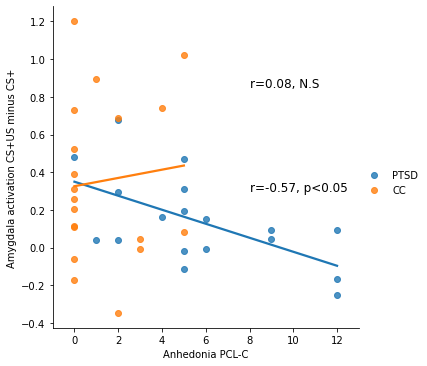

In [26]:
fgrid = sns.lmplot(x='pcl_An', y='amygdala',hue='group', data=dfpcl_amg, ci = None)
               #legend_out = True)
# need to add annotation- because its like facet grid we need to set each axis
ax1 = fgrid.axes[0,0]
    #Remove legend title
ax1.set_xlim(-1,13)
#Set labels of x and y axis
fgrid.set(xlabel='Anhedonia PCL-C', ylabel='Amygdala activation CS+US minus CS+')
ax1.text(8, .3, "r=-0.57, p<0.05", horizontalalignment='left', size='large', color='black')#, weight='semibold')
ax1.text(8, .85, "r=0.08, N.S", horizontalalignment='left', size='large', color='black')#, weight='semibold')

fgrid._legend.set_title('')
#ax.annotate("An annotation")#, horizontalalignment='left', size='medium', color='black', weight='semibold')


Text(6, 0.3, 'r=-0.37, p<0.05')

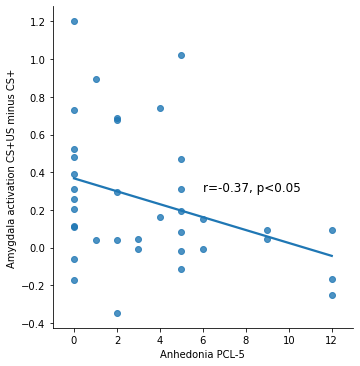

In [27]:
# Graph both groups
fgrid = sns.lmplot(x='pcl_An', y='amygdala', data=dfpcl_amg, ci = None)
               #legend_out = True)
# need to add annotation- because its like facet grid we need to set each axis
ax1 = fgrid.axes[0,0]
    #Remove legend title
ax1.set_xlim(-1,13)
#Set labels of x and y axis
fgrid.set(xlabel='Anhedonia PCL-5', ylabel='Amygdala activation CS+US minus CS+')
ax1.text(6, .3, "r=-0.37, p<0.05", horizontalalignment='left', size='large', color='black')#, weight='semibold')


#fgrid._legend.set_title('')

In [28]:
rub = scipy.stats.theilslopes(y=dfpcl_amg.pcl_An.values, x=dfpcl_amg.amygdala.values, alpha=0.9)
rub

(-2.2143454110745373, 2.3323056536938007, -5.600623875495698, 0.0)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Anhedonia PCL-5'),
 Text(0.5, 0, 'Amygdala activation CS+US minus CS+')]

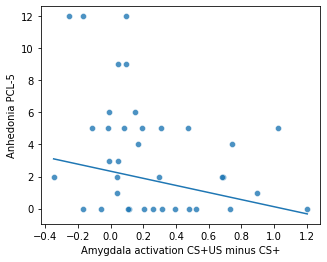

In [29]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = rub[1] + rub[0]*dfpcl_amg.amygdala
fgrid = sns.scatterplot(y='pcl_An', x='amygdala',data=dfpcl_amg, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_amg.amygdala, line)
fgrid.set(ylabel='Anhedonia PCL-5', xlabel='Amygdala activation CS+US minus CS+')

## Robust regression using Stan

In [30]:
data =  {'N': len(dfpcl_amg), 'x': dfpcl_amg['amygdala'].values, 'y': dfpcl_amg['pcl_An'].values}
sm_robust = cmdstanpy.CmdStanModel(stan_file='Stan_model/robust_reg.stan')


In [31]:
fit_robust_reg = sm_robust.sample(
  data = data,
  chains = 4,
  iter_warmup = 1000,
  iter_sampling = 1000,
  adapt_delta = .9,
  #inits = 0.2,
)

In [32]:
alpha = fit_robust_reg.stan_variable(name='alpha')
beta = fit_robust_reg.stan_variable(name='beta')

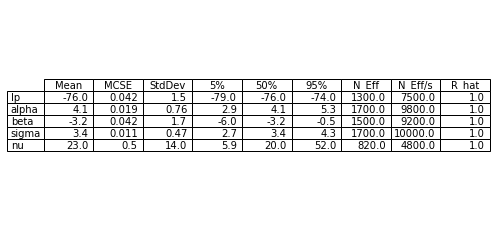

In [26]:
## Create a table
df_fit = fit_robust_reg.summary()
plt.rcParams["figure.figsize"] = [8, 4]
fig, ax =plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df_fit.values,colLabels=df_fit.columns,
         rowLabels=["lp_","alpha","beta", "sigma", "nu"],loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Anhedonia PCL-5'),
 Text(0.5, 0, 'Amygdala activation CS+US minus CS+')]

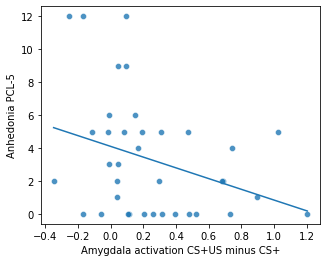

In [37]:
# plot a line based on the robust regression
plt.figure(figsize=(5,4))
line = np.mean(alpha) + np.mean(beta)*dfpcl_amg.amygdala
fgrid = sns.scatterplot(y='pcl_An', x='amygdala',data=dfpcl_amg, alpha=0.8)
#plt.plot(dfpcl_amg.amygdala, line)#,alpha = 0.8)
sns.lineplot(dfpcl_amg.amygdala, line)
fgrid.set(ylabel='Anhedonia PCL-5', xlabel='Amygdala activation CS+US minus CS+')